In [1]:
import numpy as np
import pandas as pd

In [2]:
def analytic_solution(a, b, vartheta, dt, t_max):
    x_analytic = []
    z_analytic = []
    p_x_analytic = []
    p_z_analytic = []
    time = []
    for time_step in range(0, int(t_max / dt) + 1 ):
        t = time_step * dt
        p_x = np.sin(vartheta) / (a)
        p_z = p_x * np.sinh(np.arctanh(np.cos(vartheta)) - b * t)
        x = (a / (b * np.sin(vartheta))) * ((np.tanh(b * t - np.arctanh(np.cos(vartheta)) )) + np.cos(vartheta))
        z = (a / b) * (1 / (np.sin(vartheta) * np.cosh(np.arctanh(np.cos(vartheta)) - b * t)) - 1)
        
        time.append(t)
        x_analytic.append(x)
        z_analytic.append(z)
        p_x_analytic.append(p_x)
        p_z_analytic.append(p_z)

    data = [x_analytic, z_analytic, p_x_analytic, p_z_analytic, time]
    data_df = pd.DataFrame(data)
    data_df = data_df.transpose()
    data_df.columns = ['x', 'z', 'p_x', 'p_z', 't']

    data_df = data_df[data_df['z'] >= 0]
    return data_df

In [5]:
def generate_training_time(t_max, dt):
    training_time = []
    for i in range(int(t_max/dt + 1)):
        training_time.append(i*dt)
    return training_time

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

torch.manual_seed(0)

# model
class Net(nn.Module):
    def __init__(self, hidden_size, ray_count=1):
        super(Net, self).__init__()
        self.linear_input = nn.Linear(1, hidden_size)
        self.linear_1 = nn.Linear(hidden_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, hidden_size)
        self.linear_4 = nn.Linear(hidden_size, hidden_size)
        self.linear_5 = nn.Linear(hidden_size, hidden_size)
        self.linear_6 = nn.Linear(hidden_size, hidden_size)
        self.linear_output = nn.Linear(hidden_size, ray_count * 4)

    def forward(self, x):
        x = torch.tanh(self.linear_input(x))
        x = torch.tanh(self.linear_1(x))
        x = torch.tanh(self.linear_2(x))
        x = torch.tanh(self.linear_3(x))
        x = torch.tanh(self.linear_4(x))
        x = torch.tanh(self.linear_5(x))
        x = torch.tanh(self.linear_6(x))
        x = self.linear_output(x)
        return x
    
hidden_size= 48
num_epochs = 40000
lr=0.001

a = 2
b = 1
t_max = 100 # we need to make sure that the training time is long enough
dt = 0.01
true_varthetas = [np.pi/8, np.pi/6] # determine the number of rays and the angles of the rays

In [8]:
# Generate the true solution based on the true parameters

true_solution_dfs = [analytic_solution(a, b, vartheta, dt, t_max) for vartheta in true_varthetas]

x_initials = [true_solution_df.iloc[0]['x'] for true_solution_df in true_solution_dfs]
z_initials = [true_solution_df.iloc[0]['z'] for true_solution_df in true_solution_dfs]
t_initials = [true_solution_df.iloc[0]['t'] for true_solution_df in true_solution_dfs]

x_finals = [true_solution_df.iloc[-1]['x'] for true_solution_df in true_solution_dfs]
z_finals = [true_solution_df.iloc[-1]['z'] for true_solution_df in true_solution_dfs]
t_finals = [true_solution_df.iloc[-1]['t'] for true_solution_df in true_solution_dfs]

t_max_values = t_finals # different t_final for different rays

##################################################################################
# Define the initial guesses of the parameters

vartheta_guesses = [np.pi/2 for vartheta in true_varthetas]
a_guess = 1
b_guess = 0.5

vartheta_guesses_tensor = torch.nn.Parameter(torch.tensor(vartheta_guesses, dtype=torch.float32).requires_grad_(True))
a_guess_tensor = torch.nn.Parameter(torch.tensor(a_guess, dtype=torch.float32).requires_grad_(True))
b_guess_tensor = torch.nn.Parameter(torch.tensor(b_guess, dtype=torch.float32).requires_grad_(True))

for i in range(len(vartheta_guesses)):
    print(f"vartheta_guess: pi/{round(np.pi / float(vartheta_guesses_tensor[i]), 4)}, true_vartheta: pi/{round(np.pi / float(true_varthetas[i]),4 )}")

print(f"a_guess: {a_guess_tensor.item()}, true_a: {a}")
print(f"b_guess: {b_guess_tensor.item()}, true_b: {b}")
##################################################################################

# generate training time
training_times = [generate_training_time(t_max, dt) for t_max in t_max_values]

# Convert the training data to tensors
training_times_tensor = [torch.tensor(training_time) for training_time in training_times]

##################################################################################
# Define the model, loss function, optimizer and scheduler
# Add the parameters to the optimizer, so that the optimizer can optimize the parameters

model = Net(hidden_size=hidden_size, ray_count=len(true_varthetas)) # the output of the model is the x, z, p_x, p_z values of each ray
optimizer = optim.Adam([{'params': model.parameters()}, {'params': vartheta_guesses_tensor}, {'params': a_guess_tensor}, {'params': b_guess_tensor}], lr=lr, weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2500, gamma=0.9)

##################################################################################

losses_total = []
losses_physics = []
losses_IC = []
losses_shooting = []
losses_energy = []
vartheta_list = []
a_list = []
b_list = []
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()  # Zero the gradients

    physics_x_loss = 0
    physics_z_loss = 0
    physics_p_x_loss = 0
    physics_p_z_loss = 0
    initial_position_loss_x = 0
    initial_position_loss_z = 0
    initial_momentum_loss_x = 0
    initial_momentum_loss_z = 0
    shooting_position_loss_x = 0
    shooting_position_loss_z = 0
    energy_loss = 0

    for i in range(len(training_times_tensor)): # for each ray, where i is the index of the ray
        # Define the initial and final values here

        x_initial = x_initials[i]
        z_initial = z_initials[i]
        t_initial = t_initials[i]

        x_final = x_finals[i]
        z_final = z_finals[i]
        t_final = t_finals[i]

        ray_time = torch.tensor(training_times_tensor[i]) # Define the training time tensor
        ray_time = ray_time.requires_grad_(True).view(-1, 1)

        ##################################################################################
        # Calculate the physical values

        output = model(ray_time)
        output_x = output[:, 0 + i*4].view(-1, 1)
        output_z = output[:, 1 + i*4].view(-1, 1)
        output_p_x = output[:, 2 +  i*4].view(-1, 1)
        output_p_z = output[:, 3 +  i*4].view(-1, 1)

        ##################################################################################
        # Calculate the derivatives

        xdot = torch.autograd.grad(output_x, ray_time, torch.ones_like(output_x), create_graph=True)[0]
        zdot = torch.autograd.grad(output_z, ray_time, torch.ones_like(output_z), create_graph=True)[0]
        p_x_dot = torch.autograd.grad(output_p_x, ray_time, torch.ones_like(output_p_x), create_graph=True)[0]
        p_z_dot = torch.autograd.grad(output_p_z, ray_time, torch.ones_like(output_p_z), create_graph=True)[0]

        ##################################################################################
        # Write down the Hamiltonian and calculate the energy loss

        h = (1/2) * (a_guess_tensor + b_guess_tensor * output_z)**2 * (output_p_x**2 + output_p_z**2) - 1/2
        energy_loss += torch.mean(h**2)
        
        ##################################################################################
        # Calculate the physics loss
        
        h_x = (xdot - (a_guess_tensor + b_guess_tensor * output_z)**2 * output_p_x)
        h_z = (zdot - (a_guess_tensor + b_guess_tensor * output_z)**2 * output_p_z)
        h_p_x = (p_x_dot)
        h_p_z = (p_z_dot + b_guess_tensor * (a_guess_tensor + b_guess_tensor * output_z) * (output_p_x**2 + output_p_z**2))

        physics_x_loss += torch.mean(h_x**2)
        physics_z_loss += torch.mean(h_z**2)
        physics_p_x_loss += torch.mean(h_p_x**2)
        physics_p_z_loss += torch.mean(h_p_z**2)
        
        ##################################################################################
        # Calculate the initial position and momentum loss

        x_initial_tensor = torch.tensor([x_initial], dtype=torch.float32).requires_grad_(True)
        z_initial_tensor = torch.tensor([z_initial], dtype=torch.float32).requires_grad_(True)
        t_initial_tensor= torch.tensor([t_initial], dtype=torch.float32).requires_grad_(True)

        initial_outputs = model(t_initial_tensor)

        initial_position_loss_x += (initial_outputs[0 + i *4] - x_initial_tensor)**2
        initial_position_loss_z += (initial_outputs[1 + i *4] - z_initial_tensor)**2

        initial_momentum_loss_x += (initial_outputs[2 + i *4] - torch.sin(vartheta_guesses_tensor[i])/(a_guess_tensor + b_guess_tensor * z_initial_tensor)) ** 2
        initial_momentum_loss_z += (initial_outputs[3 + i *4] - torch.cos(vartheta_guesses_tensor[i])/(a_guess_tensor + b_guess_tensor * z_initial_tensor)) ** 2
    
        ##################################################################################
        # Calculate the final position and momentum loss

        x_final_tensor = torch.tensor([x_final], dtype=torch.float32).requires_grad_(True)
        z_final_tensor = torch.tensor([z_final], dtype=torch.float32).requires_grad_(True)
        t_final_tensor = torch.tensor([t_final], dtype=torch.float32).requires_grad_(True)

        shooting_outputs = model(t_final_tensor)

        shooting_position_loss_x += (shooting_outputs[0 + i *4] - x_final_tensor)**2
        shooting_position_loss_z += (shooting_outputs[1 + i *4] - z_final_tensor)**2

        ##################################################################################

    ##################################################################################
    # Calculate the total loss and backpropagate
    physics_loss = physics_x_loss * 1e2 +  physics_z_loss * 1e2 + physics_p_x_loss * 1e4 + physics_p_z_loss * 1e4 
    IC_loss = initial_position_loss_x * 1e2 + initial_position_loss_z * 1e2 + initial_momentum_loss_x * 1e4 + initial_momentum_loss_z * 1e4
    shooting_loss = shooting_position_loss_x * 1e2 + shooting_position_loss_z * 1e2
    total_loss = (physics_x_loss * 1e2 +  physics_z_loss * 1e2 + physics_p_x_loss * 1e4 + physics_p_z_loss * 1e4 +
                    initial_position_loss_x * 1e2 + initial_position_loss_z * 1e2 + initial_momentum_loss_x * 1e4 + initial_momentum_loss_z * 1e4 +
                    shooting_position_loss_x * 1e2 + shooting_position_loss_z * 1e2 +
                    energy_loss * 1e2) 
    ##################################################################################

    total_loss.backward()  # Backpropagation
    optimizer.step()  # Update the weights

    ##################################################################################
    # Store the losses
    
    losses_physics.append(physics_loss.item())
    losses_IC.append(IC_loss.item())
    losses_shooting.append(shooting_loss.item())
    losses_energy.append(energy_loss.item())
    losses_total.append(total_loss.item())

    ##################################################################################
    # Store the parameters

    angles = []
    for angle in optimizer.param_groups[1]['params'][0]:
         
        angles.append(np.pi / (angle.item()))
    vartheta_list.append(angles)

    a_list.append(a_guess_tensor.item())
    b_list.append(b_guess_tensor.item())
  
    ##################################################################################
    # Print the losses and the parameters every 1000 epochs

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss.item():.2e}, "
              f"Physics Loss: {physics_loss.item():.2e}, "
              f"Initial Condition Loss : {IC_loss.item():.2e}, "
              f"Shoot Loss: {shooting_loss.item():.2e}, "
              f"Energy Loss: {energy_loss.item():.2e}, "
              f"LR: {optimizer.param_groups[0]['lr']}, ")
        
        for j in range(len(vartheta_guesses_tensor)):
            print(f"vartheta: pi/{np.pi / float(optimizer.param_groups[1]['params'][0][j]):.2e}")

        print(f"a: {float(optimizer.param_groups[2]['params'][0])}")
        print(f"b: {float(optimizer.param_groups[3]['params'][0])}")
    
    ##############################################################################

    # if the learning rate is too low, do not decrease the learning rate
    if optimizer.param_groups[0]['lr'] > 1e-6: 
        scheduler.step()  # Update the learning rate


vartheta_guess: pi/2.0, true_vartheta: pi/8.0
vartheta_guess: pi/2.0, true_vartheta: pi/6.0
a_guess: 1.0, true_a: 2
b_guess: 0.5, true_b: 1


  0%|          | 0/40000 [00:00<?, ?it/s]C:\Users\Selin\AppData\Local\Temp\ipykernel_3620\222865593.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_time = torch.tensor(training_times_tensor[i]) # Define the training time tensor
  3%|▎         | 1003/40000 [00:26<16:28, 39.44it/s]

Epoch 1000/40000, Total Loss: 2.80e+02, Physics Loss: 1.89e+02, Initial Condition Loss : 4.17e+01, Shoot Loss: 1.94e+01, Energy Loss: 3.06e-01, LR: 0.001, 
vartheta: pi/2.64e+00
vartheta: pi/2.46e+00
a: 1.1420470476150513
b: 0.31197723746299744


  5%|▌         | 2008/40000 [00:52<16:04, 39.41it/s]

Epoch 2000/40000, Total Loss: 1.09e+02, Physics Loss: 5.89e+01, Initial Condition Loss : 1.89e+01, Shoot Loss: 6.32e+00, Energy Loss: 2.46e-01, LR: 0.001, 
vartheta: pi/4.10e+00
vartheta: pi/3.37e+00
a: 1.3289227485656738
b: 0.5086385011672974


  8%|▊         | 3005/40000 [01:18<15:41, 39.28it/s]

Epoch 3000/40000, Total Loss: 3.95e+01, Physics Loss: 2.27e+01, Initial Condition Loss : 7.27e+00, Shoot Loss: 6.88e-01, Energy Loss: 8.84e-02, LR: 0.0009000000000000001, 
vartheta: pi/6.37e+00
vartheta: pi/4.86e+00
a: 1.4710726737976074
b: 0.752185583114624


 10%|█         | 4005/40000 [01:45<15:44, 38.12it/s]

Epoch 4000/40000, Total Loss: 8.67e+00, Physics Loss: 3.18e+00, Initial Condition Loss : 1.61e+00, Shoot Loss: 4.87e-01, Energy Loss: 3.39e-02, LR: 0.0009000000000000001, 
vartheta: pi/8.23e+00
vartheta: pi/6.10e+00
a: 1.5635231733322144
b: 0.9336354732513428


 13%|█▎        | 5003/40000 [02:11<15:19, 38.06it/s]

Epoch 5000/40000, Total Loss: 2.73e+00, Physics Loss: 1.05e+00, Initial Condition Loss : 4.86e-01, Shoot Loss: 1.47e-01, Energy Loss: 1.04e-02, LR: 0.0009000000000000001, 
vartheta: pi/9.35e+00
vartheta: pi/6.85e+00
a: 1.6349446773529053
b: 1.0458619594573975


 15%|█▌        | 6005/40000 [02:38<14:50, 38.18it/s]

Epoch 6000/40000, Total Loss: 9.71e-01, Physics Loss: 4.74e-01, Initial Condition Loss : 1.49e-01, Shoot Loss: 4.06e-02, Energy Loss: 3.07e-03, LR: 0.0008100000000000001, 
vartheta: pi/9.90e+00
vartheta: pi/7.23e+00
a: 1.6885966062545776
b: 1.1076265573501587


 18%|█▊        | 7005/40000 [03:05<14:32, 37.82it/s]

Epoch 7000/40000, Total Loss: 3.87e-01, Physics Loss: 2.45e-01, Initial Condition Loss : 4.60e-02, Shoot Loss: 1.25e-02, Energy Loss: 8.33e-04, LR: 0.0008100000000000001, 
vartheta: pi/1.01e+01
vartheta: pi/7.38e+00
a: 1.7339041233062744
b: 1.138287901878357


 20%|██        | 8005/40000 [03:31<14:28, 36.85it/s]

Epoch 8000/40000, Total Loss: 1.87e-01, Physics Loss: 1.39e-01, Initial Condition Loss : 1.62e-02, Shoot Loss: 6.10e-03, Energy Loss: 2.61e-04, LR: 0.000729, 
vartheta: pi/1.01e+01
vartheta: pi/7.39e+00
a: 1.7690556049346924
b: 1.1484968662261963


 23%|██▎       | 9006/40000 [03:58<13:51, 37.26it/s]

Epoch 9000/40000, Total Loss: 1.58e+00, Physics Loss: 1.41e+00, Initial Condition Loss : 1.17e-01, Shoot Loss: 1.94e-02, Energy Loss: 2.91e-04, LR: 0.000729, 
vartheta: pi/1.00e+01
vartheta: pi/7.33e+00
a: 1.7955676317214966
b: 1.1471049785614014


 25%|██▌       | 10005/40000 [04:27<14:22, 34.76it/s]

Epoch 10000/40000, Total Loss: 1.40e+00, Physics Loss: 1.04e+00, Initial Condition Loss : 3.36e-01, Shoot Loss: 8.20e-04, Energy Loss: 2.21e-04, LR: 0.000729, 
vartheta: pi/9.87e+00
vartheta: pi/7.23e+00
a: 1.8162082433700562
b: 1.1388927698135376


 28%|██▊       | 11003/40000 [04:57<17:49, 27.11it/s]

Epoch 11000/40000, Total Loss: 8.06e-01, Physics Loss: 4.93e-01, Initial Condition Loss : 2.70e-01, Shoot Loss: 3.45e-02, Energy Loss: 8.46e-05, LR: 0.0006561000000000001, 
vartheta: pi/9.73e+00
vartheta: pi/7.14e+00
a: 1.830949068069458
b: 1.1306854486465454


 30%|███       | 12003/40000 [05:28<13:38, 34.22it/s]

Epoch 12000/40000, Total Loss: 4.06e-01, Physics Loss: 3.40e-01, Initial Condition Loss : 5.79e-02, Shoot Loss: 2.36e-03, Energy Loss: 5.62e-05, LR: 0.0006561000000000001, 
vartheta: pi/9.58e+00
vartheta: pi/7.04e+00
a: 1.8448398113250732
b: 1.1208066940307617


 33%|███▎      | 13005/40000 [05:58<11:44, 38.34it/s]

Epoch 13000/40000, Total Loss: 7.54e-02, Physics Loss: 6.10e-02, Initial Condition Loss : 7.78e-03, Shoot Loss: 1.26e-03, Energy Loss: 5.27e-05, LR: 0.00059049, 
vartheta: pi/9.46e+00
vartheta: pi/6.96e+00
a: 1.855778455734253
b: 1.1123378276824951


 35%|███▌      | 14004/40000 [06:26<12:41, 34.15it/s]

Epoch 14000/40000, Total Loss: 5.57e-02, Physics Loss: 4.73e-02, Initial Condition Loss : 2.67e-03, Shoot Loss: 1.08e-03, Energy Loss: 4.71e-05, LR: 0.00059049, 
vartheta: pi/9.34e+00
vartheta: pi/6.88e+00
a: 1.8670728206634521
b: 1.103835940361023


 38%|███▊      | 15003/40000 [06:57<14:15, 29.22it/s]

Epoch 15000/40000, Total Loss: 4.59e-02, Physics Loss: 3.90e-02, Initial Condition Loss : 1.88e-03, Shoot Loss: 6.41e-04, Energy Loss: 4.39e-05, LR: 0.00059049, 
vartheta: pi/9.24e+00
vartheta: pi/6.81e+00
a: 1.8770620822906494
b: 1.0958151817321777


 40%|████      | 16006/40000 [07:27<11:41, 34.22it/s]

Epoch 16000/40000, Total Loss: 4.23e-02, Physics Loss: 3.62e-02, Initial Condition Loss : 1.70e-03, Shoot Loss: 6.07e-04, Energy Loss: 3.81e-05, LR: 0.000531441, 
vartheta: pi/9.15e+00
vartheta: pi/6.75e+00
a: 1.8853083848953247
b: 1.0891187191009521


 43%|████▎     | 17006/40000 [07:56<10:48, 35.48it/s]

Epoch 17000/40000, Total Loss: 4.11e-02, Physics Loss: 3.55e-02, Initial Condition Loss : 1.70e-03, Shoot Loss: 4.76e-04, Energy Loss: 3.38e-05, LR: 0.000531441, 
vartheta: pi/9.04e+00
vartheta: pi/6.69e+00
a: 1.894316554069519
b: 1.082034707069397


 45%|████▌     | 18005/40000 [08:30<10:36, 34.54it/s]

Epoch 18000/40000, Total Loss: 3.77e-02, Physics Loss: 3.28e-02, Initial Condition Loss : 1.46e-03, Shoot Loss: 3.98e-04, Energy Loss: 3.00e-05, LR: 0.0004782969, 
vartheta: pi/8.97e+00
vartheta: pi/6.63e+00
a: 1.9019498825073242
b: 1.0760217905044556


 48%|████▊     | 19003/40000 [09:02<09:52, 35.44it/s]

Epoch 19000/40000, Total Loss: 3.87e-02, Physics Loss: 3.41e-02, Initial Condition Loss : 1.60e-03, Shoot Loss: 3.31e-04, Energy Loss: 2.67e-05, LR: 0.0004782969, 
vartheta: pi/8.89e+00
vartheta: pi/6.58e+00
a: 1.9092141389846802
b: 1.0700199604034424


 50%|█████     | 20006/40000 [09:31<09:40, 34.46it/s]

Epoch 20000/40000, Total Loss: 3.86e-02, Physics Loss: 3.46e-02, Initial Condition Loss : 1.53e-03, Shoot Loss: 3.62e-04, Energy Loss: 2.19e-05, LR: 0.0004782969, 
vartheta: pi/8.81e+00
vartheta: pi/6.53e+00
a: 1.9166326522827148
b: 1.0643655061721802


 53%|█████▎    | 21005/40000 [10:01<10:32, 30.04it/s]

Epoch 21000/40000, Total Loss: 3.32e-02, Physics Loss: 3.02e-02, Initial Condition Loss : 9.05e-04, Shoot Loss: 4.43e-04, Energy Loss: 1.62e-05, LR: 0.00043046721, 
vartheta: pi/8.74e+00
vartheta: pi/6.49e+00
a: 1.9225918054580688
b: 1.059422492980957


 55%|█████▌    | 22003/40000 [10:32<09:33, 31.40it/s]

Epoch 22000/40000, Total Loss: 3.40e-01, Physics Loss: 2.07e-01, Initial Condition Loss : 1.12e-01, Shoot Loss: 1.83e-02, Energy Loss: 2.35e-05, LR: 0.00043046721, 
vartheta: pi/8.68e+00
vartheta: pi/6.45e+00
a: 1.9286882877349854
b: 1.0544742345809937


 58%|█████▊    | 23004/40000 [11:04<09:16, 30.51it/s]

Epoch 23000/40000, Total Loss: 3.16e-02, Physics Loss: 2.95e-02, Initial Condition Loss : 6.91e-04, Shoot Loss: 1.74e-04, Energy Loss: 1.26e-05, LR: 0.000387420489, 
vartheta: pi/8.63e+00
vartheta: pi/6.41e+00
a: 1.9344265460968018
b: 1.0501360893249512


 60%|██████    | 24004/40000 [11:37<09:04, 29.40it/s]

Epoch 24000/40000, Total Loss: 2.37e-01, Physics Loss: 1.44e-01, Initial Condition Loss : 7.52e-02, Shoot Loss: 1.63e-02, Energy Loss: 1.56e-05, LR: 0.000387420489, 
vartheta: pi/8.57e+00
vartheta: pi/6.37e+00
a: 1.9400373697280884
b: 1.0455780029296875


 63%|██████▎   | 25004/40000 [12:08<07:43, 32.38it/s]

Epoch 25000/40000, Total Loss: 2.71e-02, Physics Loss: 2.53e-02, Initial Condition Loss : 5.79e-04, Shoot Loss: 3.54e-04, Energy Loss: 8.88e-06, LR: 0.000387420489, 
vartheta: pi/8.51e+00
vartheta: pi/6.34e+00
a: 1.9455279111862183
b: 1.041263461112976


 65%|██████▌   | 26006/40000 [12:39<07:24, 31.52it/s]

Epoch 26000/40000, Total Loss: 3.39e-02, Physics Loss: 2.97e-02, Initial Condition Loss : 2.95e-03, Shoot Loss: 4.51e-04, Energy Loss: 8.10e-06, LR: 0.0003486784401, 
vartheta: pi/8.47e+00
vartheta: pi/6.31e+00
a: 1.9500725269317627
b: 1.0376039743423462


 68%|██████▊   | 27006/40000 [13:10<06:36, 32.81it/s]

Epoch 27000/40000, Total Loss: 2.52e-02, Physics Loss: 2.41e-02, Initial Condition Loss : 3.61e-04, Shoot Loss: 1.13e-04, Energy Loss: 6.54e-06, LR: 0.0003486784401, 
vartheta: pi/8.42e+00
vartheta: pi/6.27e+00
a: 1.9549614191055298
b: 1.033789873123169


 70%|███████   | 28006/40000 [13:41<06:13, 32.08it/s]

Epoch 28000/40000, Total Loss: 2.44e-02, Physics Loss: 2.33e-02, Initial Condition Loss : 3.69e-04, Shoot Loss: 1.76e-04, Energy Loss: 4.99e-06, LR: 0.00031381059609000004, 
vartheta: pi/8.37e+00
vartheta: pi/6.25e+00
a: 1.959199070930481
b: 1.0303843021392822


 73%|███████▎  | 29006/40000 [14:18<05:56, 30.80it/s]

Epoch 29000/40000, Total Loss: 4.81e-01, Physics Loss: 4.17e-01, Initial Condition Loss : 4.74e-02, Shoot Loss: 1.03e-02, Energy Loss: 5.79e-05, LR: 0.00031381059609000004, 
vartheta: pi/8.33e+00
vartheta: pi/6.22e+00
a: 1.963542103767395
b: 1.0269649028778076


 75%|███████▌  | 30003/40000 [14:51<04:58, 33.53it/s]

Epoch 30000/40000, Total Loss: 3.28e-01, Physics Loss: 1.98e-01, Initial Condition Loss : 1.10e-01, Shoot Loss: 2.01e-02, Energy Loss: 1.04e-05, LR: 0.00031381059609000004, 
vartheta: pi/8.29e+00
vartheta: pi/6.19e+00
a: 1.9676942825317383
b: 1.0236363410949707


 78%|███████▊  | 31003/40000 [15:22<04:38, 32.35it/s]

Epoch 31000/40000, Total Loss: 2.29e-02, Physics Loss: 2.23e-02, Initial Condition Loss : 2.79e-04, Shoot Loss: 6.36e-05, Energy Loss: 2.66e-06, LR: 0.00028242953648100003, 
vartheta: pi/8.25e+00
vartheta: pi/6.17e+00
a: 1.9714076519012451
b: 1.0207213163375854


 80%|████████  | 32004/40000 [15:56<04:27, 29.90it/s]

Epoch 32000/40000, Total Loss: 1.12e-01, Physics Loss: 9.93e-02, Initial Condition Loss : 6.32e-03, Shoot Loss: 5.04e-03, Energy Loss: 1.09e-05, LR: 0.00028242953648100003, 
vartheta: pi/8.22e+00
vartheta: pi/6.14e+00
a: 1.9751601219177246
b: 1.0177029371261597


 83%|████████▎ | 33005/40000 [16:30<03:51, 30.27it/s]

Epoch 33000/40000, Total Loss: 2.16e-02, Physics Loss: 2.13e-02, Initial Condition Loss : 1.00e-04, Shoot Loss: 7.08e-05, Energy Loss: 1.58e-06, LR: 0.00025418658283290005, 
vartheta: pi/8.18e+00
vartheta: pi/6.12e+00
a: 1.9785678386688232
b: 1.0149961709976196


 85%|████████▌ | 34005/40000 [17:04<03:11, 31.27it/s]

Epoch 34000/40000, Total Loss: 2.35e-02, Physics Loss: 2.27e-02, Initial Condition Loss : 5.12e-04, Shoot Loss: 2.12e-04, Energy Loss: 1.32e-06, LR: 0.00025418658283290005, 
vartheta: pi/8.15e+00
vartheta: pi/6.10e+00
a: 1.9819068908691406
b: 1.0122798681259155


 88%|████████▊ | 35005/40000 [17:36<02:45, 30.14it/s]

Epoch 35000/40000, Total Loss: 8.46e-02, Physics Loss: 5.67e-02, Initial Condition Loss : 2.24e-02, Shoot Loss: 5.28e-03, Energy Loss: 3.35e-06, LR: 0.00025418658283290005, 
vartheta: pi/8.12e+00
vartheta: pi/6.08e+00
a: 1.9852855205535889
b: 1.0096325874328613


 90%|█████████ | 36003/40000 [18:08<02:19, 28.55it/s]

Epoch 36000/40000, Total Loss: 4.23e-01, Physics Loss: 2.43e-01, Initial Condition Loss : 1.46e-01, Shoot Loss: 3.28e-02, Energy Loss: 1.33e-05, LR: 0.00022876792454961005, 
vartheta: pi/8.09e+00
vartheta: pi/6.06e+00
a: 1.9881129264831543
b: 1.0073416233062744


 93%|█████████▎| 37003/40000 [18:40<01:43, 28.87it/s]

Epoch 37000/40000, Total Loss: 3.76e-02, Physics Loss: 3.06e-02, Initial Condition Loss : 6.10e-03, Shoot Loss: 8.42e-04, Energy Loss: 5.48e-07, LR: 0.00022876792454961005, 
vartheta: pi/8.06e+00
vartheta: pi/6.04e+00
a: 1.9911614656448364
b: 1.0049766302108765


 95%|█████████▌| 38005/40000 [19:13<01:07, 29.74it/s]

Epoch 38000/40000, Total Loss: 2.09e-02, Physics Loss: 2.05e-02, Initial Condition Loss : 1.67e-04, Shoot Loss: 1.02e-04, Energy Loss: 5.65e-07, LR: 0.00020589113209464906, 
vartheta: pi/8.03e+00
vartheta: pi/6.03e+00
a: 1.99392831325531
b: 1.0027704238891602


 98%|█████████▊| 39004/40000 [19:45<00:33, 29.34it/s]

Epoch 39000/40000, Total Loss: 6.93e-02, Physics Loss: 4.52e-02, Initial Condition Loss : 1.95e-02, Shoot Loss: 4.32e-03, Energy Loss: 2.34e-06, LR: 0.00020589113209464906, 
vartheta: pi/8.01e+00
vartheta: pi/6.01e+00
a: 1.9966752529144287
b: 1.0005875825881958


100%|██████████| 40000/40000 [20:18<00:00, 32.83it/s]

Epoch 40000/40000, Total Loss: 3.32e-01, Physics Loss: 1.86e-01, Initial Condition Loss : 1.27e-01, Shoot Loss: 1.87e-02, Energy Loss: 5.30e-06, LR: 0.00020589113209464906, 
vartheta: pi/7.98e+00
vartheta: pi/5.99e+00
a: 1.9992427825927734
b: 0.9984720945358276


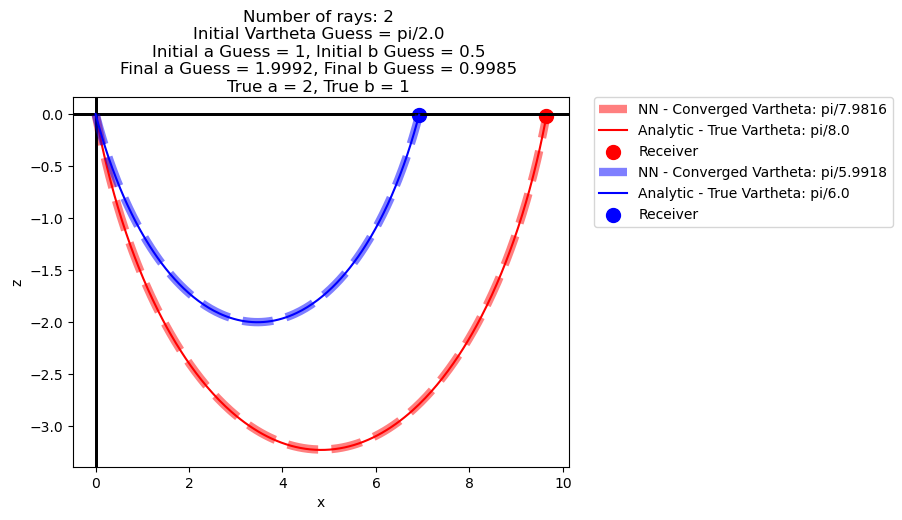

In [11]:
colors = ['red', 'blue', 'green', 'orange']
for i in range(len(training_times)):
    training_time_tensor = torch.tensor(training_times[i])
    result_outputs = model(training_time_tensor.view(-1, 1))
    result_outputs_df = pd.DataFrame(result_outputs.detach().numpy())
    # take the first 4 columns
    result_outputs_df = result_outputs_df.iloc[:, 0 + i*4 :4 + i*4]
    # rename the columns
    result_outputs_df.columns = ['x', 'z', 'p_x', 'p_z']
    # add the time column
    result_outputs_df['t'] = training_time_tensor.detach().numpy()

    # save the results
    result_outputs_df.to_excel(f"results_{i}.xlsx", index=False)
    true_solution_dfs[i].to_excel(f"true_solution_{i}.xlsx", index=False)
    
    plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=2)
    plt.plot(result_outputs_df["x"],  result_outputs_df["z"] * -1, c = colors[i],label = f"NN - Converged Vartheta: pi/{round(np.pi / float(optimizer.param_groups[1]['params'][0][i]), 4)}",  linewidth=6, linestyle='dashed', alpha = 0.5)
    plt.plot(true_solution_dfs[i]["x"], true_solution_dfs[i]["z"] * -1, c = colors[i], label = f"Analytic - True Vartheta: pi/{np.pi/true_varthetas[i]}")
    plt.scatter(true_solution_dfs[i].iloc[-1]['x'], true_solution_dfs[i].iloc[-1]['z'] * -1, c = colors[i], label = "Receiver", s = 100)
   
plt.title(f"Number of rays: {len(true_solution_dfs)} \n"
            f"Initial Vartheta Guess = pi/{np.pi/vartheta_guesses[0]} \n" # if all the vartheta guesses are the same, then only print one
            f"Initial a Guess = {a_guess}, Initial b Guess = {b_guess} \n"
            f"Final a Guess = {round(a_guess_tensor.item(), 4)}, Final b Guess = {round(b_guess_tensor.item(),4)} \n"
            f"True a = {a}, True b = {b} ", wrap=True)
#True Angles (pi/?) = {[np.pi/angle for angle in true_varthetas]}\n
plt.xlabel("x")
plt.ylabel("z")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()




Final loss: 0.3322097063064575


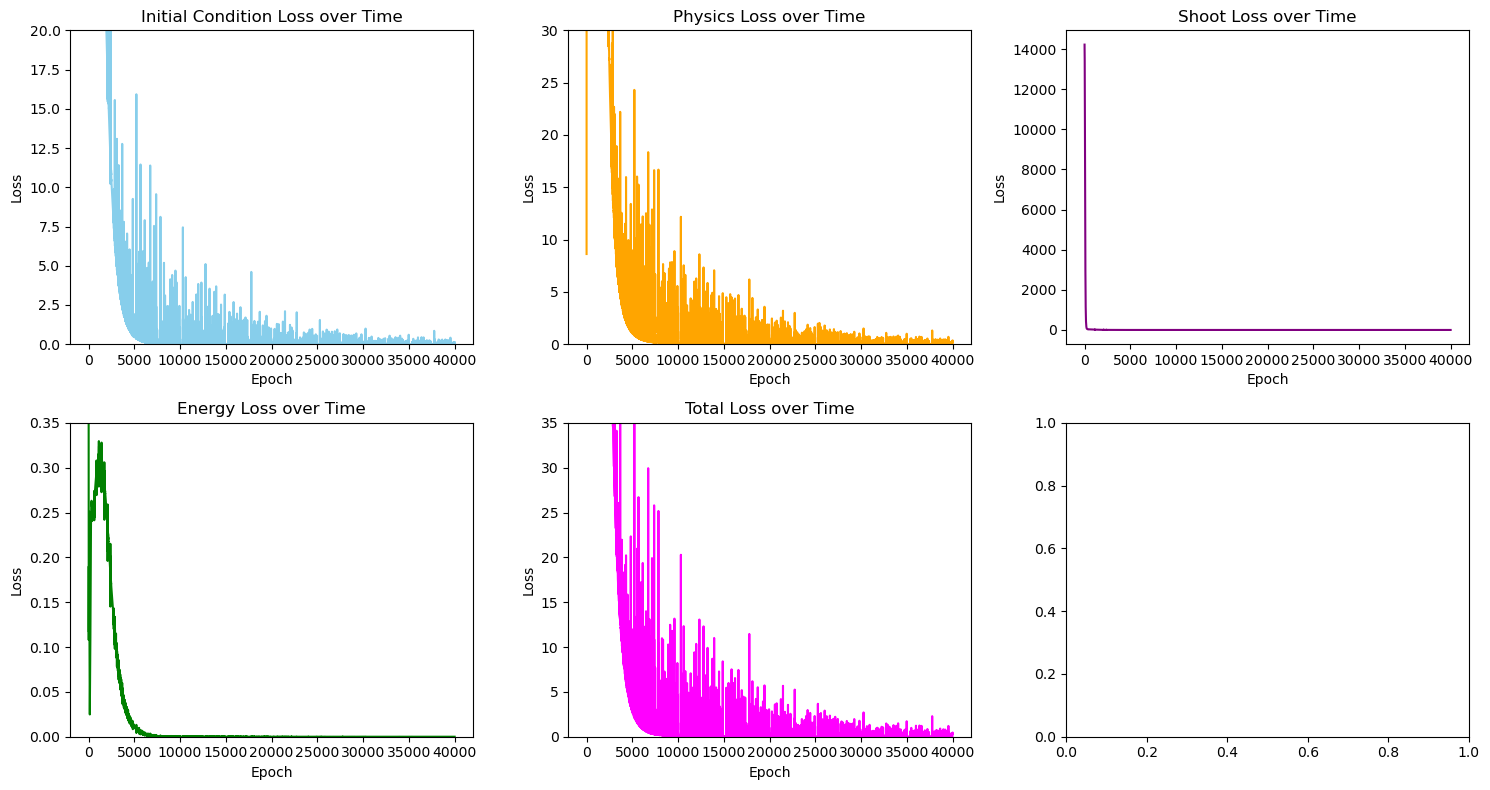

In [13]:
print('Final loss:', total_loss.item())

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Plot Initial Condition Loss
axs[0, 0].plot(losses_IC, label='Initial Condition Loss', color='skyblue')
axs[0, 0].set_title('Initial Condition Loss over Time')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_ylim(0, 20)

# Plot Physics Loss
axs[0, 1].plot(losses_physics, label='Hamiltonian Loss', color='orange')
axs[0, 1].set_title('Physics Loss over Time')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_ylim(0, 30)

# Plot Shoot Loss
axs[0, 2].plot(losses_shooting, label='Shoot Loss', color='purple')
axs[0, 2].set_title('Shoot Loss over Time')
axs[0, 2].set_xlabel('Epoch')
axs[0, 2].set_ylabel('Loss')
# axs[0, 2].set_ylim(0, 30)

# Plot Energy Loss
axs[1, 0].plot(losses_energy, label='Energy Loss', color='green')
axs[1, 0].set_title('Energy Loss over Time')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_ylim(0, 0.35)

# Plot Total Loss
axs[1, 1].plot(losses_total, label='Total Loss', color='magenta')
axs[1, 1].set_title('Total Loss over Time')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_ylim(0, 35)

plt.tight_layout()
plt.show()

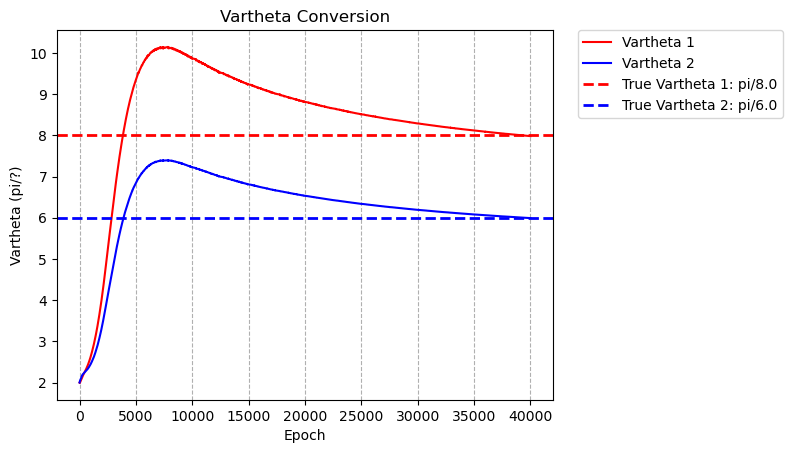

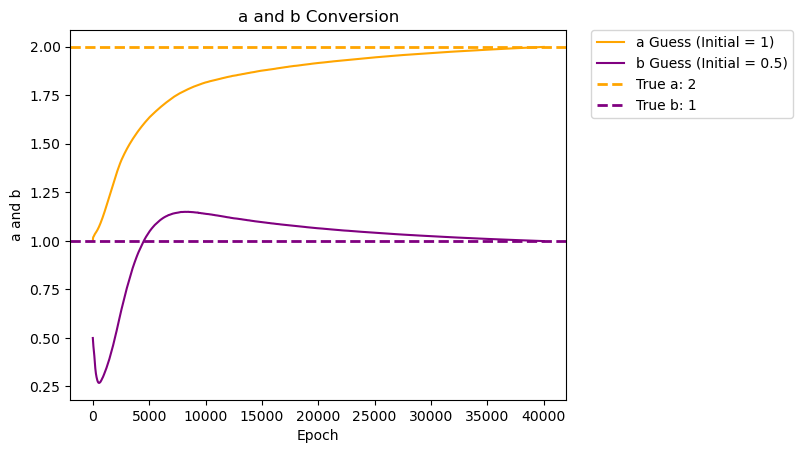

In [15]:
# convert the vartheta list to numpy array
vartheta_list = np.array(vartheta_list)

# Plot the varthetas over time
for i in range(len(vartheta_list[0])):
    plt.plot(vartheta_list[:, i], colors[i], label=f"Vartheta {i+1}")

plt.title('Vartheta Conversion')
plt.xlabel('Epoch')
plt.ylabel('Vartheta (pi/?)')

# add the true vartheta
for i in range(len(true_varthetas)):
    plt.axhline(y=np.pi / true_varthetas[i], color = colors[i], linestyle='dashed', linewidth=2, alpha=1, label=f"True Vartheta {i + 1}: pi/{np.pi/true_varthetas[i]}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# add grid
plt.grid(which='major', axis='x', linestyle='--',)
plt.show()

# plot a guess over time
plt.plot(a_list, color="orange", label=f"a Guess (Initial = {a_guess})")
plt.plot(b_list, color="purple", label=f"b Guess (Initial = {b_guess})")
plt.title('a and b Conversion')
plt.xlabel('Epoch')
plt.ylabel('a and b')
# add the true a and b
plt.axhline(y=a, color="orange", linestyle='dashed', linewidth=2, alpha=1, label=f"True a: {a}")
plt.axhline(y=b, color="purple", linestyle='dashed', linewidth=2, alpha=1, label=f"True b: {b}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()


In [25]:
print(len(ray_time))

264


In [17]:
print(x_final)

6.924274132241369


In [19]:
print(z_final)

0.006790011904797222
